In [39]:
# Notebook d'Analyse:

In [40]:
# coding: utf-8
import pandas as pd
import numpy as np
import math

In [41]:
# read the csv file
df = pd.read_csv("movie_metadata.csv", sep=',',low_memory=False)

In [42]:
df.head(5).style

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723,178,0,855,Joel David Moore,1000,7.60506e+08,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054,English,USA,PG-13,2.37e+08,2009,936,7.9,1.78,33000
1,Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,3.09404e+08,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238,English,USA,PG-13,3e+08,2007,5000,7.1,2.35,0
2,Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,2.00074e+08,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994,English,UK,PG-13,2.45e+08,2015,393,6.8,2.35,85000
3,Color,Christopher Nolan,813,164,22000,23000,Christian Bale,27000,4.48131e+08,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701,English,USA,PG-13,2.5e+08,2012,23000,8.5,2.35,164000
4,nan,Doug Walker,nan,nan,131,nan,Rob Walker,131,nan,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,nan,0,nan,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,nan,nan,nan,nan,nan,nan,12,7.1,nan,0


Features qui semblent les plus pertinentes: 
+ genres: genres auxquels appartient le film
+ title_year: année de sortie du film
+ imdb_score: note pondérée calculée selon la formule d'IMDB prenant en compte le nombre de votants. (https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK?ref_=cons_tt_rt_wtavg#)
+ director_name: nom du réalisateur
+ plot_keywords: mots-clés du synopsis

In [43]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [44]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [45]:
def get_percentage_missing(dframe):
    num = dframe.isnull().sum()
    den = len(dframe)
    return (round(num/den, 2)*100)

print(get_percentage_missing(df).sort_values())

color                         0.0
imdb_score                    0.0
actor_2_facebook_likes        0.0
country                       0.0
language                      0.0
num_user_for_reviews          0.0
movie_imdb_link               0.0
facenumber_in_poster          0.0
actor_3_name                  0.0
num_voted_users               0.0
movie_title                   0.0
cast_total_facebook_likes     0.0
genres                        0.0
actor_1_facebook_likes        0.0
actor_2_name                  0.0
actor_3_facebook_likes        0.0
duration                      0.0
actor_1_name                  0.0
movie_facebook_likes          0.0
num_critic_for_reviews        1.0
director_facebook_likes       2.0
title_year                    2.0
director_name                 2.0
plot_keywords                 3.0
content_rating                6.0
aspect_ratio                  7.0
budget                       10.0
gross                        18.0
dtype: float64


#### On va transformer les noms d'acteurs et de réalisateurs dans notre dataset pour simplifier leur traitement

In [46]:
def simplify_name(n):
    if isinstance(n, list):
        return [str.lower(i.replace(" ", "")) for i in n]
    else:
        #Check if director/actor exists. If not, return empty string
        if isinstance(n, str):
            return str.lower(n.replace(" ", ""))
        else:
            return ''

In [47]:
names=['director_name','actor_2_name','actor_3_name','actor_1_name']
for name in names:
    df[name]=df[name].apply(simplify_name)

#### On transforme les genres en listes

In [48]:
f=lambda x: x.lower().split("|")

df['genres']=df['genres'].apply(f)


In [49]:
g=lambda x: x.split('|') if isinstance(x, str) else x

df['plot_keywords']=df['plot_keywords'].apply(g)



In [50]:
df.head(10).style

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,jamescameron,723,178,0,855,joeldavidmoore,1000,7.60506e+08,"['action', 'adventure', 'fantasy', 'sci-fi']",cchpounder,Avatar,886204,4834,wesstudi,0,"['avatar', 'future', 'marine', 'native', 'paraplegic']",http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054,English,USA,PG-13,2.37e+08,2009,936,7.9,1.78,33000
1,Color,goreverbinski,302,169,563,1000,orlandobloom,40000,3.09404e+08,"['action', 'adventure', 'fantasy']",johnnydepp,Pirates of the Caribbean: At World's End,471220,48350,jackdavenport,0,"['goddess', 'marriage ceremony', 'marriage proposal', 'pirate', 'singapore']",http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238,English,USA,PG-13,3e+08,2007,5000,7.1,2.35,0
2,Color,sammendes,602,148,0,161,rorykinnear,11000,2.00074e+08,"['action', 'adventure', 'thriller']",christophwaltz,Spectre,275868,11700,stephaniesigman,1,"['bomb', 'espionage', 'sequel', 'spy', 'terrorist']",http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994,English,UK,PG-13,2.45e+08,2015,393,6.8,2.35,85000
3,Color,christophernolan,813,164,22000,23000,christianbale,27000,4.48131e+08,"['action', 'thriller']",tomhardy,The Dark Knight Rises,1144337,106759,josephgordon-levitt,0,"['deception', 'imprisonment', 'lawlessness', 'police officer', 'terrorist plot']",http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701,English,USA,PG-13,2.5e+08,2012,23000,8.5,2.35,164000
4,nan,dougwalker,nan,nan,131,nan,robwalker,131,nan,['documentary'],dougwalker,Star Wars: Episode VII - The Force Awakens,8,143,,0,nan,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,nan,nan,nan,nan,nan,nan,12,7.1,nan,0
5,Color,andrewstanton,462,132,475,530,samanthamorton,640,7.30587e+07,"['action', 'adventure', 'sci-fi']",darylsabara,John Carter,212204,1873,pollywalker,1,"['alien', 'american civil war', 'male nipple', 'mars', 'princess']",http://www.imdb.com/title/tt0401729/?ref_=fn_tt_tt_1,738,English,USA,PG-13,2.637e+08,2012,632,6.6,2.35,24000
6,Color,samraimi,392,156,0,4000,jamesfranco,24000,3.3653e+08,"['action', 'adventure', 'romance']",j.k.simmons,Spider-Man 3,383056,46055,kirstendunst,0,"['sandman', 'spider man', 'symbiote', 'venom', 'villain']",http://www.imdb.com/title/tt0413300/?ref_=fn_tt_tt_1,1902,English,USA,PG-13,2.58e+08,2007,11000,6.2,2.35,0
7,Color,nathangreno,324,100,15,284,donnamurphy,799,2.00807e+08,"['adventure', 'animation', 'comedy', 'family', 'fantasy', 'musical', 'romance']",bradgarrett,Tangled,294810,2036,m.c.gainey,1,"['17th century', 'based on fairy tale', 'disney', 'flower', 'tower']",http://www.imdb.com/title/tt0398286/?ref_=fn_tt_tt_1,387,English,USA,PG,2.6e+08,2010,553,7.8,1.85,29000
8,Color,josswhedon,635,141,0,19000,robertdowneyjr.,26000,4.58992e+08,"['action', 'adventure', 'sci-fi']",chrishemsworth,Avengers: Age of Ultron,462669,92000,scarlettjohansson,4,"['artificial intelligence', 'based on comic book', 'captain america', 'marvel cinematic universe', 'superhero']",http://www.imdb.com/title/tt2395427/?ref_=fn_tt_tt_1,1117,English,USA,PG-13,2.5e+08,2015,21000,7.5,2.35,118000
9,Color,davidyates,375,153,282,10000,danielradcliffe,25000,3.01957e+08,"['adventure', 'family', 'fantasy', 'mystery']",alanrickman,Harry Potter and the Half-Blood Prince,321795,58753,rupertgrint,3,"['blood', 'book', 'love', 'potion', 'professor']",http://www.imdb.com/title/tt0417741/?ref_=fn_tt_tt_1,973,English,UK,PG,2.5e+08,2009,11000,7.5,2.35,10000


### Write the dataframe into a CSV file

In [120]:
df=df.fillna('')
df.to_csv('movie_db.csv',sep='\t',index=False,encoding='utf-8')

In [70]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [58]:
df1 = pd.read_csv("movie_metadata.csv", sep=',',low_memory=False)
df1=df1.dropna()

### Visualize the repartition of movie IMDB scores vs the movie's budget

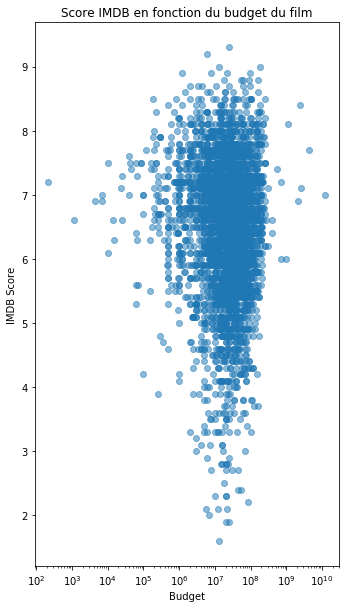

In [20]:
x=df1['budget']
y=df1['imdb_score']

fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(121)
plt.scatter(x, y, alpha=0.5)

plt.title("Score IMDB en fonction du budget du film")
ax.set_xscale('log')
ax.set_ylabel("IMDB Score")
ax.set_xlabel("Budget")
plt.show()

### Visualize the repartition of movie IMDB scores vs the movie's gross revenue

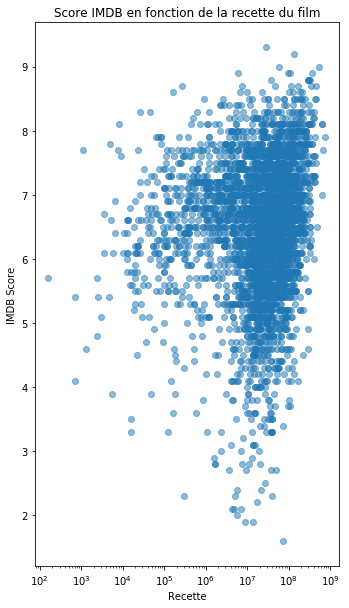

In [21]:
x=df1['gross']
y=df1['imdb_score']

fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(121)
plt.scatter(x, y, alpha=0.5)

plt.title("Score IMDB en fonction de la recette du film")
ax.set_xscale('log')
ax.set_ylabel("IMDB Score")
ax.set_xlabel("Recette")
plt.show()

In [59]:

dfcat = pd.DataFrame(df['genres'].values.tolist())

In [60]:
dfcat.head()

,0,1,2,3,4,5,6,7
0,action,adventure,fantasy,sci-fi,None,None,None,None
1,action,adventure,fantasy,None,None,None,None,None
2,action,adventure,thriller,None,None,None,None,None
3,action,thriller,None,None,None,None,None,None
4,documentary,None,None,None,None,None,None,None


In [61]:
df4 = df.reset_index()
df4[['cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8']]=dfcat

In [62]:
df4.head()
df4.columns

Index(['index', 'color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'cat1', 'cat2',
       'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8'],
      dtype='object')

In [63]:
df4=df4.drop(['index', 'color','director_name', 'num_critic_for_reviews',
       'duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'genres',
       'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language','actor_2_facebook_likes','aspect_ratio',
       'movie_facebook_likes','cat4', 'cat5', 'cat6',
       'cat7', 'cat8'],axis=1)
df4.head()

,gross,country,content_rating,budget,title_year,imdb_score,cat1,cat2,cat3
0,760505847.0,USA,PG-13,237000000.0,2009.0,7.9,action,adventure,fantasy
1,309404152.0,USA,PG-13,300000000.0,2007.0,7.1,action,adventure,fantasy
2,200074175.0,UK,PG-13,245000000.0,2015.0,6.8,action,adventure,thriller
3,448130642.0,USA,PG-13,250000000.0,2012.0,8.5,action,thriller,None
4,NaN,NaN,NaN,NaN,NaN,7.1,documentary,None,None


#### Preprocessing the dataset for the exploration

In [82]:
# import preprocessing from sklearn
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [65]:
print(df4.shape)
df4.dropna()
print(df4.shape)

(5043, 9)
(2460, 9)


,gross,country,content_rating,budget,title_year,imdb_score,cat1,cat2,cat3
0,760505847.0,USA,PG-13,237000000.0,2009.0,7.9,action,adventure,fantasy
1,309404152.0,USA,PG-13,300000000.0,2007.0,7.1,action,adventure,fantasy
2,200074175.0,UK,PG-13,245000000.0,2015.0,6.8,action,adventure,thriller
5,73058679.0,USA,PG-13,263700000.0,2012.0,6.6,action,adventure,sci-fi
6,336530303.0,USA,PG-13,258000000.0,2007.0,6.2,action,adventure,romance


In [69]:
df4=pd.get_dummies(df4)

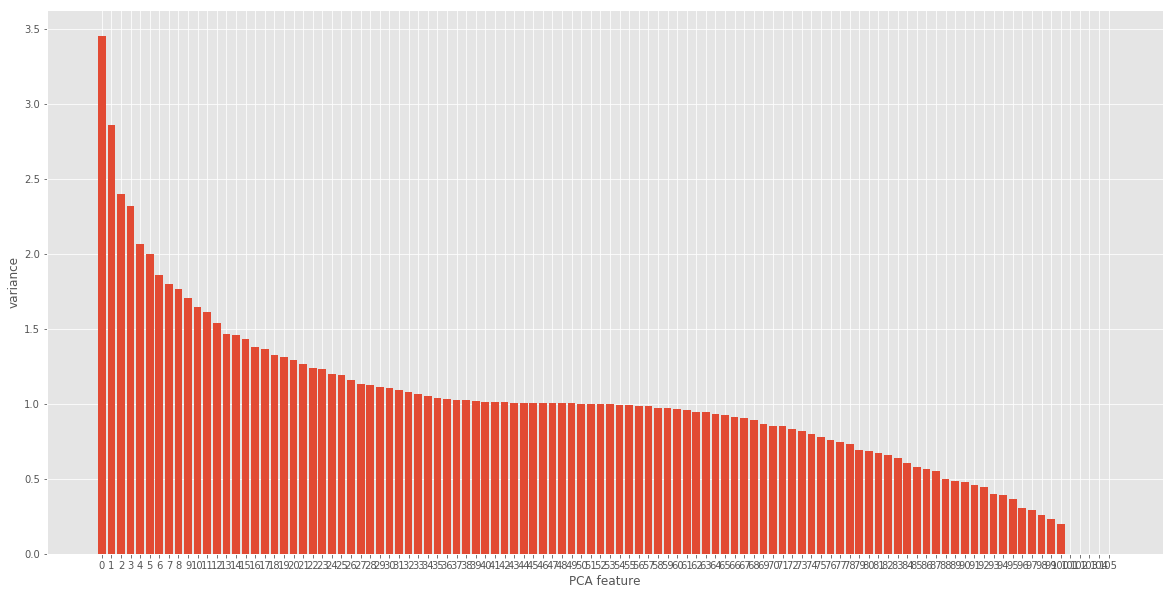

In [75]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)


# Fit the pipeline to the dataset
pipeline.fit(df4)

# Plot the explained variances
features = range(pca.n_components_)
fig=plt.figure(figsize=(20,10))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()



[[ 0.05606483 -2.09608281  0.3675586 ]
 [-1.30063892  0.63648516 -0.76670348]
 [ 2.41092643 -1.88285574 -0.62469857]
 [ 4.39197617  2.82448127  1.31266641]
 [-2.44725992 -0.18826569  1.76758886]
 [-0.85951184 -0.99177699 -0.67646796]
 [ 2.9433153   2.06455144  0.32678587]
 [-2.1911252   1.79988431 -0.17724126]
 [-0.61806783 -1.76689982  1.72906155]
 [-0.80038178  1.18698833 -2.73592632]
 [-0.56996956  0.14103355  2.81633862]
 [ 0.57156442  2.26629577 -1.32803387]
 [ 1.73657118  0.72838065  1.51244403]
 [ 1.8363748  -2.83560437 -1.49735309]
 [-2.81000046  1.34345353  2.02801905]
 [ 0.40034085 -1.75906441 -1.30008991]
 [-1.17006555 -0.55171288  0.87025095]
 [ 0.6629482  -1.25218258  1.21893834]
 [-1.67882562  1.60786813 -1.50260396]
 [ 1.26939649 -2.41829769 -0.17739893]
 [-0.21655725  2.12170641  0.48111194]
 [ 1.02960528  0.57048514 -0.42599212]
 [-2.14853761  1.0414727   0.75137006]
 [ 2.68502298 -0.82602733  0.12455252]
 [-0.9294187  -1.72129257  3.24696669]
 [ 1.62176656  1.6350297 

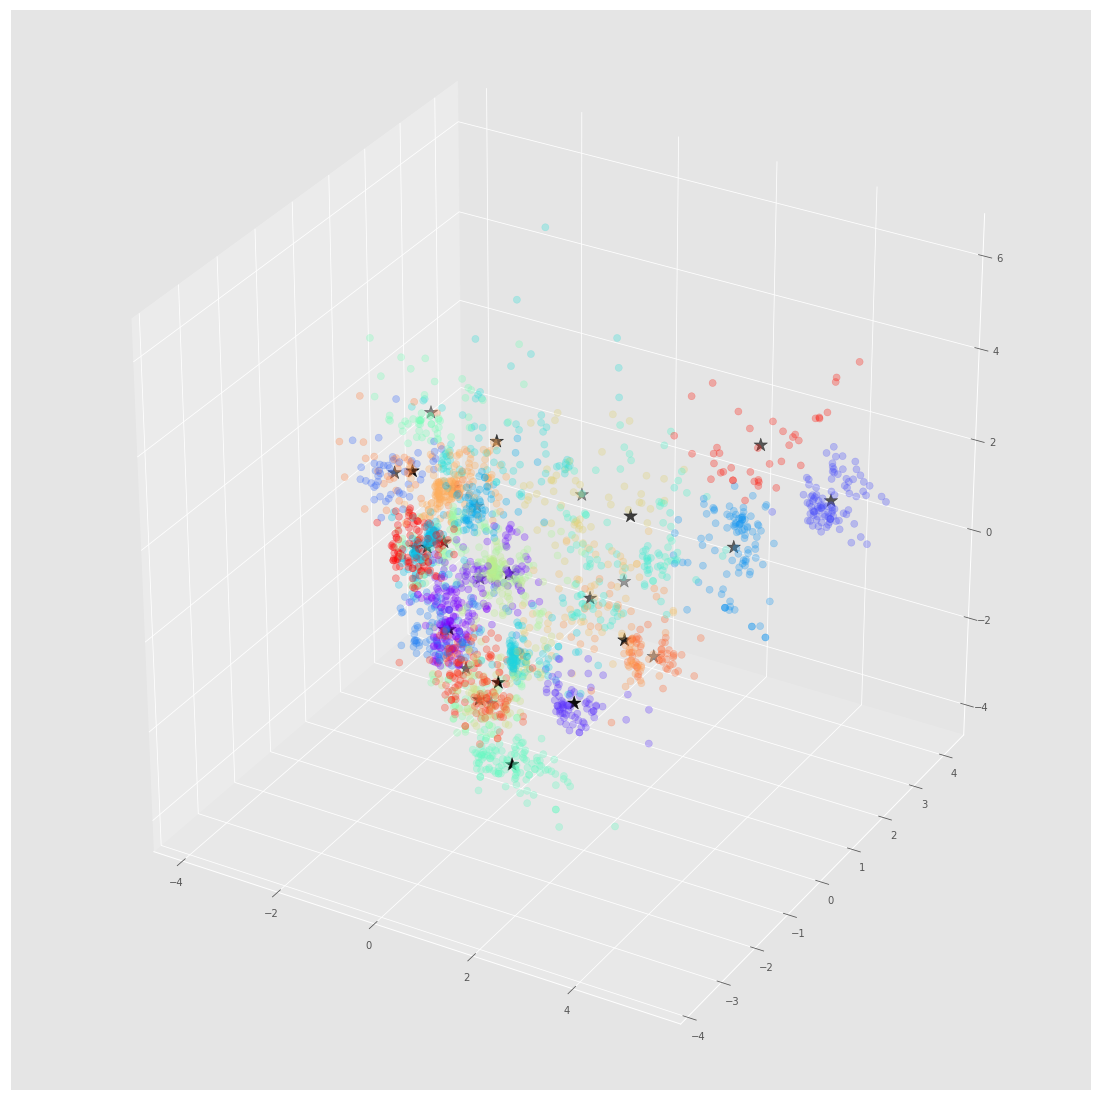

In [104]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=3)

# Create KMeans instance: kmeans
k=30
kmeans = KMeans(n_clusters=k)

scaled_features=scaler.fit_transform(df4)

pca.fit(scaled_features)

pca_features=pca.transform(scaled_features)

kmeans = kmeans.fit(pca_features)

labels = kmeans.predict(pca_features)

C = kmeans.cluster_centers_

colors = cm.rainbow(np.linspace(0, 1, k))
fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)
ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2],c=colors[kmeans.labels_],alpha=0.3,s=50)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=200)

print(C)

In [103]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
dbscan=dbscan.fit(pca_features)
print(max(list(dbscan.labels_)))

28
